## ✅ **Plan for Conversion**
1. **Create new folders** inside `train`, `test`, and `val`:  
   - `train/annotations/`  
   - `val/annotations/`  
   - `test/annotations/`  
   - These will store `.xml` (Pascal VOC) or `.json` (COCO) files.

2. **Write a script to convert YOLO to Pascal VOC XML**  
   - Read YOLO `.txt` files and extract bounding boxes.  
   - Convert to XML format with image size information.  
   - Save in the `annotations/` folder.

3. **(Alternative) Write a script to convert YOLO to COCO JSON**  
   - Read YOLO `.txt` files and extract bounding boxes.  
   - Store data in COCO JSON format.  
   - Save in the `annotations/` folder.

---

### 📌 **Which format do you prefer?**  
- **Pascal VOC (`.xml`)** (Recommended for Faster R-CNN in TensorFlow)  
- **COCO (`.json`)** (If you want to try EfficientDet later)  

To convert YOLO `.txt` annotations to Pascal VOC `.xml` format, follow these steps:

### **1️⃣ Create a Folder Structure**
- Inside each dataset split (`train`, `val`, `test`), create a new folder for XML annotations.
  ```
  /train
    /images
    /labels
    /xml_annotations
  /val
    /images
    /labels
    /xml_annotations
  /test
    /images
    /labels
    /xml_annotations
  ```

### **2️⃣ Convert YOLO `.txt` to Pascal VOC `.xml`**
You'll need:
- Image dimensions (width, height)
- Class mapping (for your case, class `0` is "Building")

### **3️⃣ Python Script for Conversion**
The script will:
- Read `.txt` files
- Convert YOLO format (relative `x_center, y_center, width, height`) to Pascal VOC format (absolute `xmin, ymin, xmax, ymax`)
- Save `.xml` files in the respective `xml_annotations` folder.

### **Step 1: Import Libraries**

**Purpose:** Import necessary libraries for:
- `os`: For handling file system paths and directory operations.
- `cv2`: For reading images and manipulating image data.
- `xml.etree.ElementTree as ET`: For creating and writing XML files.
- `matplotlib.pyplot as plt`: For visualizing images and annotations.

In [11]:
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

In [2]:
# Mapping from YOLO class IDs to human-readable class names
class_mapping = {0: "Building"}

In [3]:
# Directory paths for labels and images
label_dir = "../Data/tiny_object_detection_yolo/filtered_labels"
image_dir = "../Data/tiny_object_detection_yolo/filtered_images"

# Subfolders representing different splits of the dataset
sub_folders = ["train", "test", "val"]

### **Step 2:** Define the yolo_to_voc function 
- to convert bounding box coordinates from YOLO format to VOC format.

In [8]:
# Function to convert YOLO bounding box format to VOC format (xmin, ymin, xmax, ymax)
def yolo_to_voc(yolo_bbox, img_width, img_height):
    # Convert YOLO normalized coordinates to pixel-based coordinates
    class_id, x_center, y_center, width, height = map(float, yolo_bbox)
    
    # Scale the YOLO box dimensions from relative values to image pixel values
    x_center, y_center, width, height = (
        x_center * img_width,
        y_center * img_height,
        width * img_width,
        height * img_height,
    )

    # Calculate the coordinates of the bounding box corners
    x_min = int(round(x_center - width / 2))
    y_min = int(round(y_center - height / 2))
    x_max = int(round(x_center + width / 2))
    y_max = int(round(y_center + height / 2))

    # Return the class name and the bounding box coordinates
    return class_mapping[int(class_id)], x_min, y_min, x_max, y_max

### **Step 3:** Define the create_voc_xml function 
- to create an XML file for each image, including bounding boxes and class labels.

In [9]:
# Function to create VOC XML annotation file for an image
def create_voc_xml(image_name, img_width, img_height, bboxes, output_path):
    # Create the root element of the XML
    annotation = ET.Element("annotation")

    # Add folder and filename details
    ET.SubElement(annotation, "folder").text = "images"
    ET.SubElement(annotation, "filename").text = image_name
    ET.SubElement(annotation, "path").text = os.path.join(output_path, image_name)

    # Add image size (width, height, depth) to XML
    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(img_width)
    ET.SubElement(size, "height").text = str(img_height)
    ET.SubElement(size, "depth").text = "3"  # Assuming 3-channel RGB image

    # Add object details (bounding boxes and class name) to XML
    for bbox in bboxes:
        obj = ET.SubElement(annotation, "object")
        ET.SubElement(obj, "name").text = bbox[0]  # Class name (e.g., "Building")
        ET.SubElement(obj, "pose").text = "Unspecified"
        ET.SubElement(obj, "truncated").text = "0"
        ET.SubElement(obj, "difficult").text = "0"

        # Add bounding box coordinates (xmin, ymin, xmax, ymax)
        bndbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bndbox, "xmin").text = str(bbox[1])
        ET.SubElement(bndbox, "ymin").text = str(bbox[2])
        ET.SubElement(bndbox, "xmax").text = str(bbox[3])
        ET.SubElement(bndbox, "ymax").text = str(bbox[4])

    # Write the XML tree to a file
    tree = ET.ElementTree(annotation)
    xml_filename = os.path.join(output_path, image_name.replace(".jpg", ".xml").replace(".png", ".xml"))
    tree.write(xml_filename)

### **Step 4:** Loop through each dataset 
- Split (train, test, val), read YOLO annotations, convert them to VOC format, and save them as XML files.

In [10]:
# Loop through each subfolder (train, test, val) to process the dataset
for split in sub_folders:
    labels_path = os.path.join(label_dir, split)  # Path to YOLO labels for this split
    images_path = os.path.join(image_dir, split)  # Path to images for this split
    output_xml_path = os.path.join(label_dir, split, "xml_annotations")  # Output directory for VOC XMLs

    os.makedirs(output_xml_path, exist_ok=True)  # Ensure the XML output folder exists

    # Process each annotation file in the folder
    for label_file in os.listdir(labels_path):
        if label_file.endswith(".txt"):  # Only process text files containing YOLO annotations
            image_file = label_file.replace(".txt", ".png")  # Assuming images are in PNG format
            
            image_path = os.path.join(images_path, image_file)  # Path to the corresponding image
            label_path = os.path.join(labels_path, label_file)  # Path to the annotation file
            
            # Check if the image file exists
            if os.path.exists(image_path):
                img = cv2.imread(image_path)  # Read the image using OpenCV
                img_height, img_width, _ = img.shape  # Get the image dimensions

                # Read the YOLO annotations from the file
                with open(label_path, "r") as f:
                    lines = f.readlines()

                bboxes = []  # List to store bounding box data
                # Process each YOLO annotation line
                for line in lines:
                    yolo_bbox = line.strip().split()  # Split the line into components
                    class_name, x_min, y_min, x_max, y_max = yolo_to_voc(yolo_bbox, img_width, img_height)  # Convert to VOC format
                    bboxes.append((class_name, x_min, y_min, x_max, y_max))  # Append the bounding box data

                # Create and save the VOC XML annotation for the image
                create_voc_xml(image_file, img_width, img_height, bboxes, output_xml_path)
    
    # Print a confirmation message for each dataset split
    print(f"✅ Conversion completed for {split} set. XML annotations saved in {output_xml_path}")

✅ Conversion completed for train set. XML annotations saved in ../Data/tiny_object_detection_yolo/filtered_labels/train/xml_annotations
✅ Conversion completed for test set. XML annotations saved in ../Data/tiny_object_detection_yolo/filtered_labels/test/xml_annotations
✅ Conversion completed for val set. XML annotations saved in ../Data/tiny_object_detection_yolo/filtered_labels/val/xml_annotations


In [12]:
# Paths for the visualization
IMAGES_FOLDER = "../Data/tiny_object_detection_yolo/filtered_images/train"
ANNOTATIONS_FOLDER = "../Data/tiny_object_detection_yolo/filtered_labels/train/xml_annotations"

### **Step 5:** Define functions to parse VOC XML 
- Annotations and visualize bounding boxes on the images using OpenCV and Matplotlib.

In [13]:
# Function to parse VOC XML file and extract object details
def parse_voc_annotation(xml_file):
    tree = ET.parse(xml_file)  # Parse the XML file
    root = tree.getroot()  # Get the root element of the XML
    objects = []  # List to store the objects (bounding boxes)

    # Loop through each object in the XML
    for obj in root.findall("object"):
        name = obj.find("name").text  # Get the object class name
        bbox = obj.find("bndbox")  # Get the bounding box
        xmin = int(float(bbox.find("xmin").text))
        ymin = int(float(bbox.find("ymin").text))
        xmax = int(float(bbox.find("xmax").text))
        ymax = int(float(bbox.find("ymax").text))
        objects.append((name, xmin, ymin, xmax, ymax))  # Append object data

    return objects

In [16]:
# Function to visualize the image with its annotations (bounding boxes)
def visualize_annotation(image_file, annotation_file):
    image = cv2.imread(image_file)  # Read the image using OpenCV
    
    if image is None:
        print(f"Error: Image at {image_file} could not be loaded.")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB (for Matplotlib)

    objects = parse_voc_annotation(annotation_file)  # Parse the annotations from the XML file

    # Draw bounding boxes on the image
    for (name, xmin, ymin, xmax, ymax) in objects:
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)  # Draw blue bounding box
        cv2.putText(image, name, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)  # Add text (class name)

    # Display the image with annotations using Matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")  # Hide the axis
    plt.show()

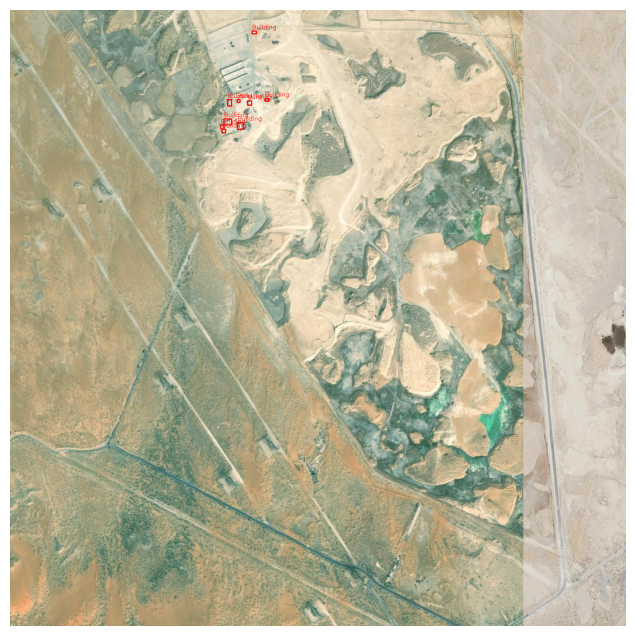

In [22]:
# Example to visualize a specific image and its annotations
sample_image_name = "1_Renew_Licenced_Small_1_2022.png"  # Image filename (no full path)
image_path = os.path.join(IMAGES_FOLDER, sample_image_name)  # Full image path
annotation_path = os.path.join(ANNOTATIONS_FOLDER, sample_image_name.replace(".png", ".xml"))  # Corresponding annotation file

# Visualize the annotation for the sample image
visualize_annotation(image_path, annotation_path)

### Summary of the Process:

- 1️⃣. **YOLO to VOC Conversion**: It converts object detection annotations from YOLO format (which uses normalized bounding boxes) to VOC  format (which uses pixel-based bounding boxes). The conversion includes creating Pascal VOC XML files for each image that contain class labels and bounding box coordinates.

- 2️⃣. **Processing Dataset**: The script processes annotation files in different dataset splits (`train`, `test`, `val`), and for each image, it reads the YOLO annotations, converts them to VOC format, and saves them as XML files in an output directory.

- 3️⃣. **Visualization**: It provides functionality to visualize the annotations by drawing bounding boxes on the corresponding images using OpenCV and displaying them with Matplotlib.